In [3]:
from FeatureExtraction import FeatureExtraction
import os
import pickle
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier

from functions import display_metrics, plot_roc_curves_multiclass

train_image_dataset_path = "datasets/train"
test_image_dataset_path = "datasets/test"

features_main_folder = "features"

train_features_folder = "train"
test_features_folder = "test"

required_features_files = [
    "GLCMFeatures.csv",
    "HOGFeatures.csv",
    "PCA_HOG_Features.csv",
    "Combined_Features.csv"
]


missing_training_files = [file for file in required_features_files if not os.path.exists(os.path.join(features_main_folder, train_features_folder, file))]
if missing_training_files:
    FeatureExtraction(train_image_dataset_path, features_main_folder, train_features_folder )
    
missing_testing_files = [file for file in required_features_files if not os.path.exists(os.path.join(features_main_folder, test_features_folder, file))]
if missing_testing_files:     
    FeatureExtraction(test_image_dataset_path, features_main_folder, test_features_folder )       

train_data = pd.read_csv("features/train/GLCMFeatures.csv")
test_data = pd.read_csv("features/test/GLCMFeatures.csv")

x_train = train_data.drop(columns=["Images", "Label"])
x_test = test_data.drop(columns=["Images", "Label"])

y_train = train_data["Label"]
y_test = test_data["Label"]

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Performance Metrics for MLP Classifier
Accuracy: 0.32
Precision: 0.25
Recall: 0.32
F1-Score: 0.28
AUC Score: 0.80



c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


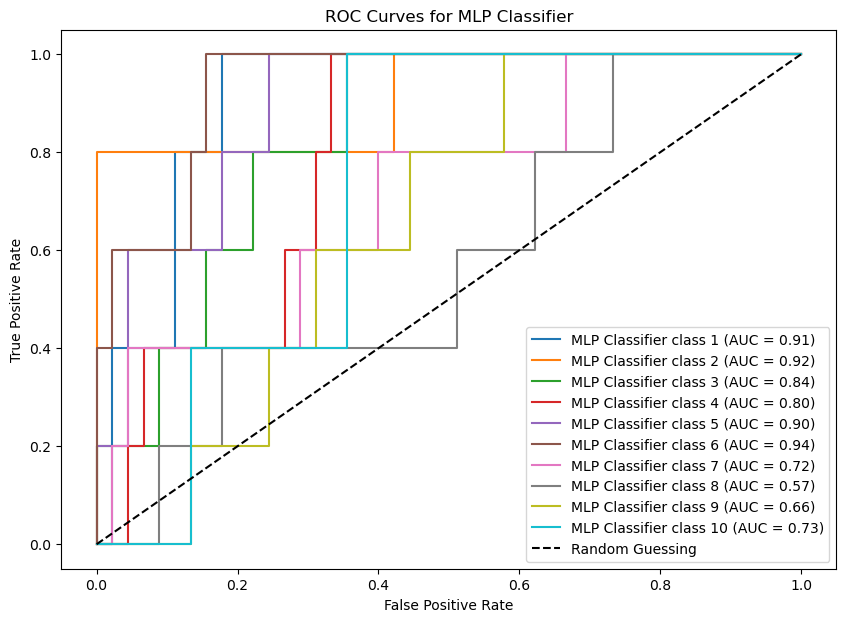

Performance Metrics for Gaussian Naive Bayes
Accuracy: 0.26
Precision: 0.16
Recall: 0.26
F1-Score: 0.19
AUC Score: 0.78



c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


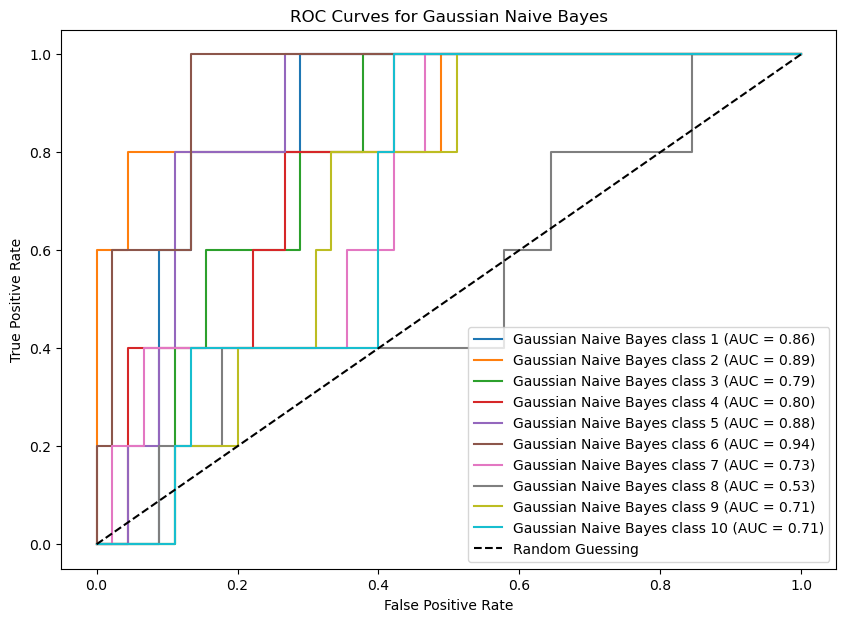

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Performance Metrics for Decision Tree
Accuracy: 0.32
Precision: 0.30
Recall: 0.32
F1-Score: 0.30
AUC Score: 0.65



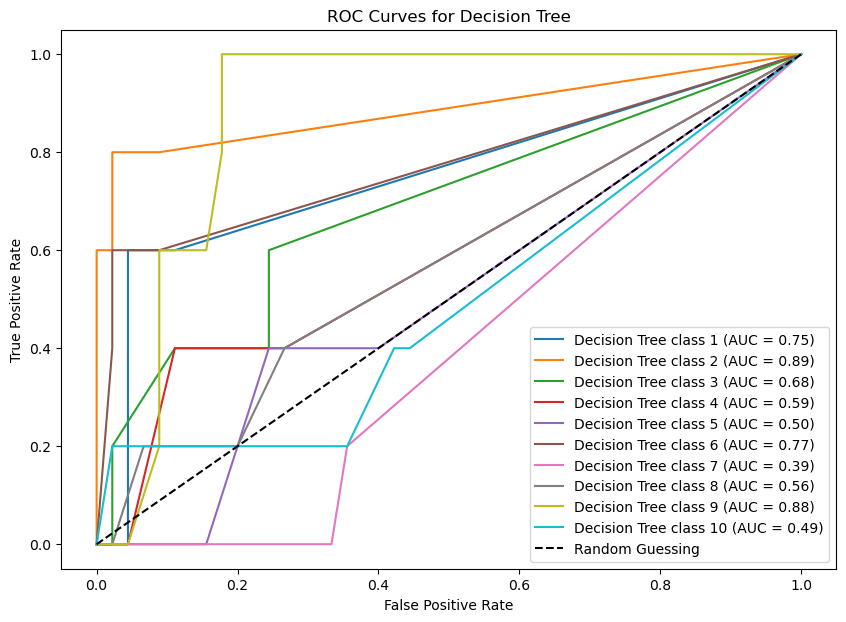

Performance Metrics for K-Nearest Neighbors
Accuracy: 0.34
Precision: 0.32
Recall: 0.34
F1-Score: 0.32
AUC Score: 0.74



c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


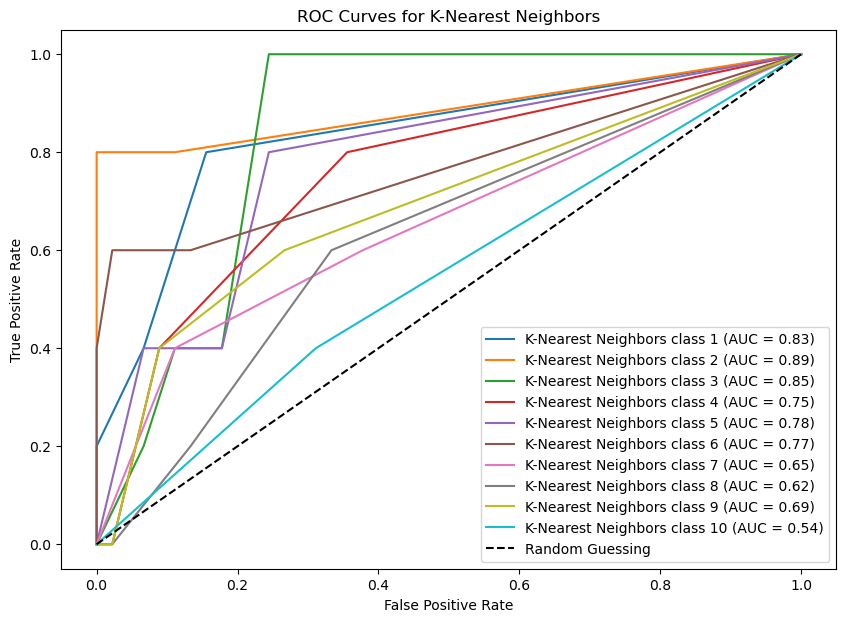

In [4]:
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_binarized.shape[1]

os.makedirs("models", exist_ok=True)

# ============================================ 1. MLP model ============================================
if os.path.exists("models/MLP-model.pkl"):
    with open("models/MLP-model.pkl", "rb") as f:
        mlp_best = pickle.load(f)
else:
    mlp = MLPClassifier(max_iter=1000, random_state=42)
    mlp_best = GridSearchCV(mlp, mlp_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    mlp_best.fit(x_train_scaled, y_train)

    os.makedirs("models", exist_ok=True)
    with open("models/MLP-model.pkl", "wb") as f:
        pickle.dump(mlp_best, f)
mlp_y_pred = mlp_best.predict(x_test_scaled)
mlp_y_score = mlp_best.predict_proba(x_test_scaled)
display_metrics("MLP Classifier", y_test, mlp_y_pred, y_test_binarized, mlp_y_score)
plot_roc_curves_multiclass(y_test_binarized, mlp_y_score, "MLP Classifier", n_classes)

# ============================================ 2. Naive Bayes Model ============================================
nb_model_path = "models/NB-model.pkl"
if os.path.exists(nb_model_path):
    with open(nb_model_path, "rb") as f:
        nb = pickle.load(f)
else:
    nb = GaussianNB()
    nb.fit(x_train_scaled, y_train)
    with open(nb_model_path, "wb") as f:
        pickle.dump(nb, f)

nb_y_pred = nb.predict(x_test_scaled)
nb_y_score = nb.predict_proba(x_test_scaled)
display_metrics("Gaussian Naive Bayes", y_test, nb_y_pred, y_test_binarized, nb_y_score)
plot_roc_curves_multiclass(y_test_binarized, nb_y_score, "Gaussian Naive Bayes", n_classes)


# ============================================ 3. Decision Tree Model ============================================
dt_model_path = "models/DT-model.pkl"
if os.path.exists(dt_model_path):
    with open(dt_model_path, "rb") as f:
        dt_best = pickle.load(f)
else:
    dt = DecisionTreeClassifier(random_state=42)
    dt_best = GridSearchCV(dt, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    dt_best.fit(x_train_scaled, y_train)
    with open(dt_model_path, "wb") as f:
        pickle.dump(dt_best, f)

dt_y_pred = dt_best.predict(x_test_scaled)
dt_y_score = dt_best.predict_proba(x_test_scaled)
display_metrics("Decision Tree", y_test, dt_y_pred, y_test_binarized, dt_y_score)
plot_roc_curves_multiclass(y_test_binarized, dt_y_score, "Decision Tree", n_classes)


# ============================================ 4. K-Nearest Neighbors Model ============================================
knn_model_path = "models/KNN-model.pkl"
if os.path.exists(knn_model_path):
    with open(knn_model_path, "rb") as f:
        knn = pickle.load(f)
else:
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train_scaled, y_train)
    with open(knn_model_path, "wb") as f:
        pickle.dump(knn, f)

knn_y_pred = knn.predict(x_test_scaled)
knn_y_score = knn.predict_proba(x_test_scaled)
display_metrics("K-Nearest Neighbors", y_test, knn_y_pred, y_test_binarized, knn_y_score)
plot_roc_curves_multiclass(y_test_binarized, knn_y_score, "K-Nearest Neighbors", n_classes)